In [1]:
%source /opt/ros/noetic/setup.bash

UsageError: Line magic function `%source` not found.


In [2]:
from pathlib import Path
import os
import rospkg
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import re
import random
from tqdm import trange

LATENT_CODE_SIZE = 128
amcm = 24

class Lambda(nn.Module):
    def __init__(self, function):
        super(Lambda, self).__init__()
        self.function = function

    def forward(self, x):
        return self.function(x)

def load_voxel_grids(file_paths):
    voxel_grids = []
    voxel_size = 0.0075
    grid_size = (40, 40, 40)
    num_files = len(file_paths)
    assert num_files % 2 == 0, "The number of file paths should be even."

    for i in range(0, num_files, 2):

        # Grid 1 is the TSDF as a point cloud 
        grid1 = np.zeros(grid_size)
        pcd1 = o3d.io.read_point_cloud(file_paths[i])
        points1 = np.asarray(pcd1.points)
        distances = np.asarray(pcd1.colors)[:, [0]]

        grid1 = np.zeros((40, 40, 40), dtype=np.float32)
        indices = (points1 // voxel_size).astype(int)
        grid1[tuple(indices.T)] = distances.squeeze()
        # grid1[points1[:, 0], points1[:, 1], points1[:, 2]] = 1
        grid1 = grid1[np.newaxis, :, :, :]
        
        # Grid 2 is the occluded voxel locations
        grid2 = np.zeros(grid_size)
        pcd2 = o3d.io.read_point_cloud(file_paths[i + 1])
        points2 = np.asarray(pcd2.points).astype(int)
        grid2[points2[:, 0], points2[:, 1], points2[:, 2]] = 1
        grid2 = grid2[np.newaxis, :, :, :]

        # Concatenate the two voxel grids along the channel dimension (dim=0)
        combined_grid = np.concatenate((grid1, grid2), axis=0)
        voxel_grids.append(combined_grid)

    return voxel_grids

def split_combined_voxel_grids(combined_grids):
    voxel_grids = []
    for combined_grid in combined_grids:
        # Remove the channel dimension (dim=0) to get the individual voxel grids
        grid1 = combined_grid[0, :, :, :]
        grid2 = combined_grid[1, :, :, :]

        voxel_grids.append(grid1)
        voxel_grids.append(grid2)

    return voxel_grids

# Step 2: Autoencoder Architecture (define the neural network)
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(

            nn.Conv3d(2, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),

            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),

            nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Flatten(),  # Flatten the 3D tensor into a 1D vector
            nn.Linear(128 * 10 * 10 * 10, 512)  # Map to the desired latent dimension of 1000
        )

        # Decoder layers
        self.decoder = nn.Sequential(

            nn.Linear(512, 128 * 10 * 10 * 10),  # Map from the latent space back to the decoder input shape
            nn.Unflatten(1, (128, 10, 10, 10)),  # Reshape the tensor back to 4D (batch_size, channels, height, width, depth)
            nn.ReLU(),

            nn.Conv3d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv3d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv3d(32, 2, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
        # Encoder layers
        # self.encoder = nn.Sequential(
        #     nn.Conv3d(2, 32, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.BatchNorm3d(32),  # Replace MaxPool3d with BatchNorm3d

        #     nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.BatchNorm3d(64),  # Replace MaxPool3d with BatchNorm3d

        #     nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.BatchNorm3d(128),

        #     nn.Flatten(),  # Flatten the 3D tensor into a 1D vector
        #     nn.Linear(8192000, 1000)  # Map to the desired latent dimension of 1000
        # )

        # # Decoder layers
        # self.decoder = nn.Sequential(
        #     nn.Linear(1000, 8192000),  # Map from the latent space back to the decoder input shape
        #     nn.Unflatten(1, (128, 10, 10, 10)),  # Reshape the tensor back to 4D (batch_size, channels, height, width, depth)
        #     nn.ReLU(),
        #     nn.Conv3d(128, 64, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.BatchNorm3d(64),  # Add BatchNorm3d to handle the increased spatial dimensions
        #     nn.Upsample(scale_factor=2),

        #     nn.Conv3d(64, 32, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.BatchNorm3d(32),  # Add BatchNorm3d to handle the increased spatial dimensions
        #     nn.Upsample(scale_factor=2),

        #     nn.Conv3d(32, 2, kernel_size=3, stride=1, padding=1),
        #     nn.Sigmoid()
        # )

        # # Encoder layers
        # self.encoder = nn.Sequential(
        #     nn.Conv3d(2, 32, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm3d(32),
        #     nn.LeakyReLU(negative_slope=0.2, inplace=True),

        #     nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm3d(64),
        #     nn.LeakyReLU(negative_slope=0.2, inplace=True),

        #     nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1),
        #     nn.LeakyReLU(negative_slope=0.2, inplace=True),

        #     nn.Flatten(),  # Flatten the 3D tensor into a 1D vector
        #     nn.Linear(128*10*10*10, 1000)  # Map to the desired latent dimension of 1000
        # )

        # # Decoder layers
        # self.decoder = nn.Sequential(
        #     nn.Linear(1000, 128 * 10 * 10 * 10),  # Map from the latent space back to the decoder input shape
        #     nn.BatchNorm1d(128 * 10 * 10 * 10),
        #     nn.LeakyReLU(negative_slope=0.2, inplace=True),
        #     nn.Unflatten(1, (128, 10, 10, 10)),  # Reshape the tensor back to 4D (batch_size, channels, height, width, depth)
            
        #     nn.ConvTranspose3d(128, 64, kernel_size = 4, stride = 1),
        #     nn.BatchNorm3d(64),
        #     nn.LeakyReLU(negative_slope=0.2, inplace=True),

        #     nn.ConvTranspose3d(64, 32, kernel_size = 4, stride = 2, padding = 1),
        #     nn.BatchNorm3d(32),
        #     nn.LeakyReLU(negative_slope=0.2, inplace=True),

        #     nn.ConvTranspose3d(32, 2, kernel_size = 4, stride = 2, padding = 1)
        # )

        # self.encoder = nn.Sequential(
        #     nn.Conv3d(in_channels = 2, out_channels = 1 * amcm, kernel_size = 4, stride = 2, padding = 1),
        #     nn.BatchNorm3d(1 * amcm),
        #     nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
        #     nn.Conv3d(in_channels = 1 * amcm, out_channels = 2 * amcm, kernel_size = 4, stride = 2, padding = 1),
        #     nn.BatchNorm3d(2 * amcm),
        #     nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
        #     nn.Conv3d(in_channels = 2 * amcm, out_channels = 4 * amcm, kernel_size = 4, stride = 2, padding = 1),
        #     nn.BatchNorm3d(4 * amcm),
        #     nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
        #     nn.Conv3d(in_channels = 4 * amcm, out_channels = LATENT_CODE_SIZE * 2, kernel_size = 4, stride = 1),
        #     nn.BatchNorm3d(LATENT_CODE_SIZE * 2),
        #     nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
        #     nn.Flatten(),
        #     # Lambda(lambda x: x.reshape(x.shape[0], -1)),
        #     nn.Linear(in_features = LATENT_CODE_SIZE * 2, out_features=LATENT_CODE_SIZE)
        # )
        
        
        # self.decoder = nn.Sequential(            
        #     # nn.Linear(in_features = LATENT_CODE_SIZE, out_features=LATENT_CODE_SIZE * 2),
        #     # nn.BatchNorm1d(LATENT_CODE_SIZE * 2),
        #     # nn.LeakyReLU(negative_slope=0.2, inplace=True),

        #     nn.Linear(1000, 128 * 10 * 10 * 10),  # Map from the latent space back to the decoder input shape
        #     nn.Unflatten(1, (128, 10, 10, 10)),  # Reshape the tensor back to 4D (batch_size, channels, height, width, depth)
            
        #     # Lambda(lambda x: x.reshape(-1, LATENT_CODE_SIZE * 2, 1, 1, 1)),
        #     nn.ReLU(),
        #     nn.ConvTranspose3d(in_channels = LATENT_CODE_SIZE * 2, out_channels = 4 * amcm, kernel_size = 4, stride = 1),
        #     nn.BatchNorm3d(4 * amcm),
        #     nn.LeakyReLU(negative_slope=0.2, inplace=True),

        #     nn.ConvTranspose3d(in_channels = 4 * amcm, out_channels = 2 * amcm, kernel_size = 4, stride = 2, padding = 1),
        #     nn.BatchNorm3d(2 * amcm),
        #     nn.LeakyReLU(negative_slope=0.2, inplace=True),

        #     nn.ConvTranspose3d(in_channels = 2 * amcm, out_channels = 1 * amcm, kernel_size = 4, stride = 2, padding = 1),
        #     nn.BatchNorm3d(1 * amcm),
        #     nn.LeakyReLU(negative_slope=0.2, inplace=True),

        #     nn.ConvTranspose3d(in_channels = 1 * amcm, out_channels = 2, kernel_size = 4, stride = 2, padding = 1)
        # )

    def forward(self, x):
        # x = torch.cat((x1, x2), dim=1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Step 3: Training
# Training function
def train_autoencoder(train_data, val_data, num_epochs, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Training on:", device)
    autoencoder = Autoencoder().to(device)
    # use binary cross entropy
    # criterion = nn.MSELoss()

    # try 2 loss function one for the 
    criterion = nn.BCELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

    train_losses = [] 
    val_losses = []    

    t = trange(num_epochs)
    for epoch in t:
        running_loss = 0.0
        for batch in train_loader:  # Loop through batches in DataLoader
            inputs = batch.to(device)
            optimizer.zero_grad()
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:  # Loop through batches in DataLoader
                inputs = batch.to(device)
                outputs = autoencoder(inputs)
                loss = criterion(outputs, inputs)
                val_loss += loss.item() * inputs.size(0)
            val_loss /= len(val_loader.dataset)
            val_losses.append(val_loss)

        t.set_description(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    plot_autoencoder(train_losses, val_losses)

    return autoencoder

def plot_autoencoder(train, val):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train, label='Train Loss')
    plt.plot(epochs, val, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def encode_voxel_grids(autoencoder, new_voxel_grids):
    # new_voxel_grids = torch.tensor(new_voxel_grids.reshape(-1, 40*40*40), dtype=torch.float32)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    new_voxel_grids = new_voxel_grids.clone().detach().to(device)
    encoded_voxel = autoencoder.encoder(new_voxel_grids)
    return encoded_voxel

def decode_voxel_grids(autoencoder, encoded_voxel):
    decoded_voxel = autoencoder.decoder(encoded_voxel)
    return decoded_voxel

# Function to get file paths for all .pcd files in the specified directory
def get_pcd_file_paths(directory_path):
    file_paths = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".pcd"):
            file_path = os.path.join(directory_path, filename)
            file_paths.append(file_path)
    # Sort the file paths numerically based on the numeric part of the filename
    file_paths.sort(key=lambda x: (int(re.search(r'\d+', x).group()), "occ" in x, x))
    return file_paths

def clean_files(directory_path):
    groups = {}  # Dictionary to store groups of files

    all_files = os.listdir(directory_path)
    # Identify groups based on filenames
    for file_name in all_files:
        if file_name.endswith(".pcd"):
            group_name = file_name.split("_")[0]  # Extract group name (e.g., p18)
            file_type = file_name.split("_")[1]   # Extract file type (e.g., tsdf or occu)

            if group_name not in groups:
                groups[group_name] = set()

            groups[group_name].add(file_type)

    # Delete groups where required files are not present
    for group_name, file_types in groups.items():
        if "tsdf.pcd" not in file_types or "occu.pcd" not in file_types:
            for file_type in file_types:
                file_to_delete = os.path.join(directory_path, f"{group_name}_{file_type}")
                os.remove(file_to_delete)
            print(f"Deleted group {group_name}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Training on: cuda


Epoch 50/50, Train Loss: 0.0277, Val Loss: 0.0472: 100%|██████████| 50/50 [02:55<00:00,  3.51s/it]


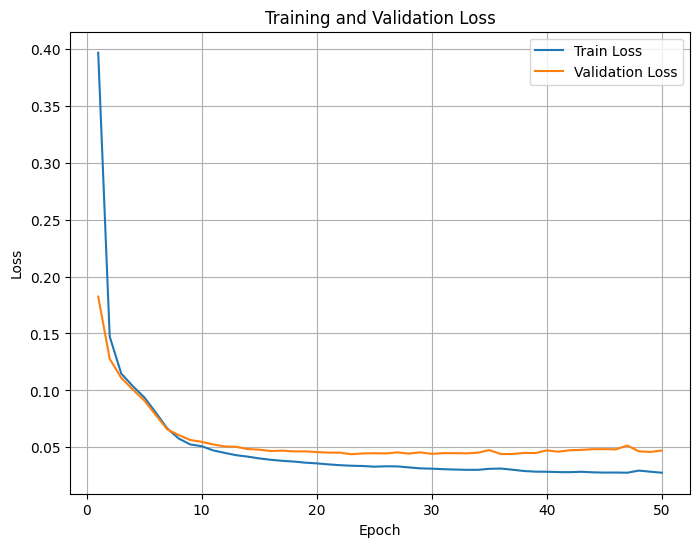

In [3]:
rospack = rospkg.RosPack()
# pkg_root = Path(rospack.get_path("active_search"))
data_folder_path = "/home/pitcher/dev_ws/thesis_ws/active_search/src/active_search/training_test/"
clean_files(data_folder_path)
file_paths = get_pcd_file_paths(data_folder_path)  # List of file paths to your .pcd files
voxel_grids = load_voxel_grids(file_paths)

random.shuffle(voxel_grids)

# Convert to PyTorch tensors and flatten the voxel grids
# voxel_tensors = torch.tensor(np.asarray(voxel_grids).reshape(-1, 40*40*40), dtype=torch.float32)
voxel_tensors = torch.tensor(np.asarray(voxel_grids), dtype=torch.float32)

num_data = int(voxel_tensors.shape[0]*0.9)
data = voxel_tensors[:num_data]
holdout_data = voxel_tensors[num_data:]

# Split into training and validation sets
num_train_samples = int(data.shape[0]*0.8)
train_data = data[:num_train_samples]
val_data = data[num_train_samples:]

# Define autoencoder parameters
num_epochs = 50
batch_size = 16

# Train the autoencoder
trained_autoencoder = train_autoencoder(train_data, val_data, num_epochs, batch_size)


In [4]:
save_model = True
if save_model:
    save_path = '/home/pitcher/dev_ws/thesis_ws/active_search/src/active_search/models/autoencoder_weights.pth'
    torch.save(trained_autoencoder.state_dict(), save_path)

In [5]:
encoded_voxel = encode_voxel_grids(trained_autoencoder, holdout_data)

print(encoded_voxel.shape)
decoded_voxel = decode_voxel_grids(trained_autoencoder, encoded_voxel)
print(decoded_voxel.shape)

holdout_grids = split_combined_voxel_grids(holdout_data.cpu().data.numpy())
decoded_grids = split_combined_voxel_grids(decoded_voxel.cpu().data.numpy())

torch.Size([74, 512])
torch.Size([74, 2, 40, 40, 40])


In [6]:
print(len(voxel_grids))
print(voxel_grids[0].shape)

test_grids = split_combined_voxel_grids(voxel_grids)

print(test_grids[0].shape)


739
(2, 40, 40, 40)
(40, 40, 40)


In [7]:
def to_pcd(grid):
    threshold = 0.1
    points = np.argwhere(grid > threshold) #* voxel_size
    distances = np.expand_dims(grid[grid > threshold], 1)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    return pcd

active = True

def kill_o3d(sender):
    global active
    active = False

tsdf_exists = False
reset_bb = False

o3d.core.Device("cuda:0")

vis = o3d.visualization.VisualizerWithKeyCallback()

vis.register_key_callback(ord("X"), kill_o3d)

vis.create_window(window_name = "Depth Camera")

pcd = o3d.io.read_point_cloud(file_paths[0])

test_pcd = to_pcd(test_grids[0])

holdout_pc_grid = holdout_grids[0]

decoded_pc_grid = decoded_grids[0]


holdout_pcd = to_pcd(holdout_pc_grid)
decode_pcd = to_pcd(decoded_pc_grid)
decode_pcd.translate(np.asarray([0,-41,0]))

frame = o3d.geometry.TriangleMesh.create_coordinate_frame(0.05)

vis.add_geometry(holdout_pcd, reset_bounding_box = True)
vis.add_geometry(decode_pcd, reset_bounding_box = True)
vis.add_geometry(frame, reset_bounding_box = reset_bb)
vis.update_renderer()

while active:

    vis.poll_events()
    vis.update_renderer()

vis.destroy_window()